In [200]:
import importlib
importlib.reload(loss)

<module 'stepping.loss' from '/home/lewington/code/ml/neural_synthesis/stepping/loss.py'>

In [201]:
import torch
from torchvision import models, transforms
from torch import nn, optim
import torch.nn.functional as F

from utils import layers, hooking, img, stats
from stepping import loss, closure

In [202]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg19 = models.vgg19(pretrained=True).to(device)
for param in vgg19.features.parameters(): # stop training the net
    param.requires_grad = False

In [203]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device) 
normalization_layer = layers.Normalization(normalization_mean, normalization_std).to(device)

useful_layers = list(list(vgg19.children())[0])
useful_layers.insert(0, normalization_layer)

vgg = nn.Sequential(*useful_layers)

In [204]:
vgg_layers = list(vgg.children())

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

In [205]:
hooker = hooking.Hooker(vgg)
hooker.attach_hooks("texture_hooks", [3, 6, 19, 26, 37])
hook_bag = hooker.get_bag()
vgg = layers.clipped_model(vgg, hooker.last_hooked_index())
hook_bag.hooks

defaultdict(<function utils.hooking.HookBag.__init__.<locals>.<lambda>()>,
            {'texture_hooks': [<utils.hooking.Hook at 0x7f6c1ef7de80>,
              <utils.hooking.Hook at 0x7f6c1ef7d320>]})

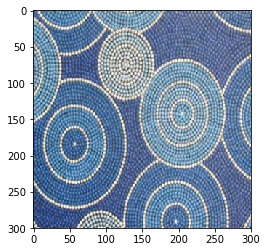

In [206]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(300),
    transforms.ToTensor(),
])

example_texture = img.image_loader("data/original/rings-2.jpg", transform)
img.show_image(example_texture)

In [207]:
vgg(example_texture)
target = stats.extract_features(hook_bag.get_hook("texture_hooks"), stats.gram_matrix)

def texture_loss_fn(target_grams, sample_features):
    sample_grams = [stats.gram_matrix(feature) for feature in sample_features]
    loss = 0
    
    for i in range(len(sample_grams)):
        loss += F.mse_loss(sample_grams[i], target_grams[i])
    
    return loss * 1000000

texture_loss = loss.LossFn(target, hook_bag.get_hook("texture_hooks"), texture_loss_fn)

In [208]:
collector = loss.LossCollector()
collector.add_loss_fn("texture", texture_loss)

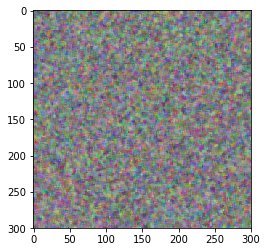

In [209]:
sample_texture = img.random_image(5, 300)
img.show_image(sample_texture)

inputs = {
    "sample": (sample_texture, "texture"),
}

optimizer = optim.LBFGS([sample_texture])

In [210]:
stepper = closure.Stepper(inputs, vgg, collector, optimizer)

In [ ]:
for i in range(64):
    optimizer.step(stepper.loss_fn)

img.save_image(sample_texture)

[tensor(0.1681, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1679, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1679, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1678, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1678, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1677, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1676, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1675, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1674, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1673, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1673, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1672, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1671, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1670, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1670, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1669, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1668, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1668, device='cuda:0'

[tensor(0.1582, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1582, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1581, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1580, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1580, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1579, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1579, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1579, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1578, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1577, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1577, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1576, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1575, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1575, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1575, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1574, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1573, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1572, device='cuda:0'

[tensor(0.1503, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1502, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1502, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1501, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1501, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1501, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1500, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1499, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1499, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1498, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1498, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1497, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1497, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1496, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1496, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1495, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1495, device='cuda:0', grad_fn=<MulBackward>)]
[tensor(0.1494, device='cuda:0'